In [1]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

import datalad.api as dl

%matplotlib inline

/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


## Get Dataset using datalad
This tutorial will be using the Paranoia dataset and the extracted ROI timeseries csv files.

In [3]:
# data_dir = '/Volumes/Engram/Data/Paranoia'
data_dir = '/Users/naeun-oh/Paranoia/'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(data_dir):
    dl.clone(source='https://gin.g-node.org/ljchang/Paranoia', path=datadir)

# Initialize dataset
ds = dl.Dataset(data_dir)

In [ ]:
# Get cropped & denoised nifti files for subject's 1's run 1 
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', 'sub-tb2994*denoise_smooth6mm_task-story_run-1*nii.gz')))

In [ ]:
# Get cropped & denoised node timeseries data for all subjects for all runs
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*_nodeTimeSeries.csv')))

In [4]:
# Get participant demographic/behavioral file
result = ds.get(os.path.join(data_dir, 'participants.tsv'))

get(ok): participants.tsv (file) [from origin...]


## Behavior Data
First, let's discuss what metrics are appropriate for measuring behavioral similarity. We will run simulations and visualizations.

In [5]:
# First, choose number of subjects and simulate behavior chosen from random distribution
n_subs = 100
behav_raw = np.random.randn(n_subs)
behav = rankdata(behav_raw)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  import sys


Nearest Neighbors model

Let's see what we are assuming the similarity structure should look like if we use Euclidean distance as our metric. The matrix below is subjects-by-subjects, with subjects ordered according to behavioral score (from low to high).

Text(0.5, 1.0, 'Nearest neighbor\n(model: Euclidean distance(i,j))')

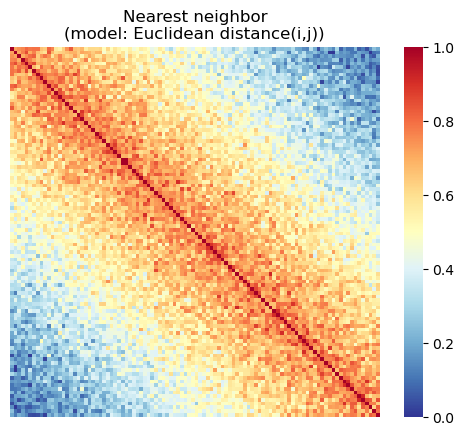

In [6]:
nn_mtx = np.zeros((n_subs, n_subs)) # initialize a similarity matrix
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = 1-(abs(behav[i]-behav[j])/n_subs) 
            dist_ij += np.random.randn()*noise_factor # add some random noise
            nn_mtx[i,j] = dist_ij
            nn_mtx[j,i] = dist_ij
            
nn_mtx = scale_mtx(nn_mtx)
np.fill_diagonal(nn_mtx, 1)    

fig, ax = plt.subplots()
sns.heatmap(sort_square_mtx(nn_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
ax.set_title("Nearest neighbor\n(model: Euclidean distance(i,j))")

We can see that in the NN case, we see the highest similarity right slong the diagonal. This means we're assuming that a subject should always look most similar to his or her immediate neighbors, regardless of where they fall on the scale more generally.

Now, compare with the AnnaK case using the mean.

Text(0.5, 1.0, 'Anna Karenina\n(model: Euclidean distance(i,j))')

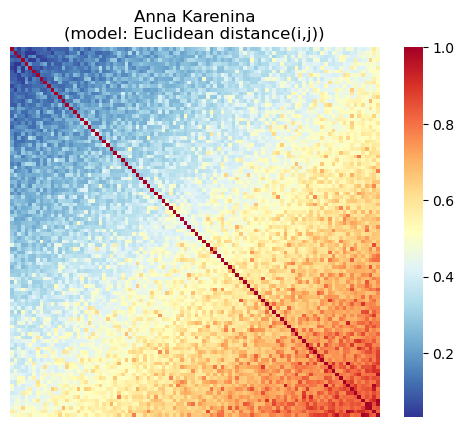

In [8]:
annak_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = np.mean([behav[i]/n_subs, behav[j]/n_subs]) # calculate distance between i and j as 
            dist_ij += abs(np.random.randn()*noise_factor) # add some random noise
            annak_mtx[i,j] = dist_ij
            annak_mtx[j,i] = dist_ij

annak_mtx = scale_mtx(annak_mtx)
np.fill_diagonal(annak_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(annak_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False);
ax.set_title("Anna Karenina\n(model: Euclidean distance(i,j))")

We can see that similarity increases as we move down and to the right, meaning that we expect that high scorers will look similar to other high scorers, but lower scorers don't look similar to one another or to high scorers.

Another way to visualize the similarity structure of these matrices is to project them into a two-dimensional embedding using t-SNE (t-Distributed Stochastic Neighbor Embedding). In the righthand panels in the figure below, each dor represents a subject, and subjects are colored according to their behavioral score. In this embedding, similar observations (subjects) appear nearby, while dissimilar observations appear further away. (You can ingore the component axes for interpretation)

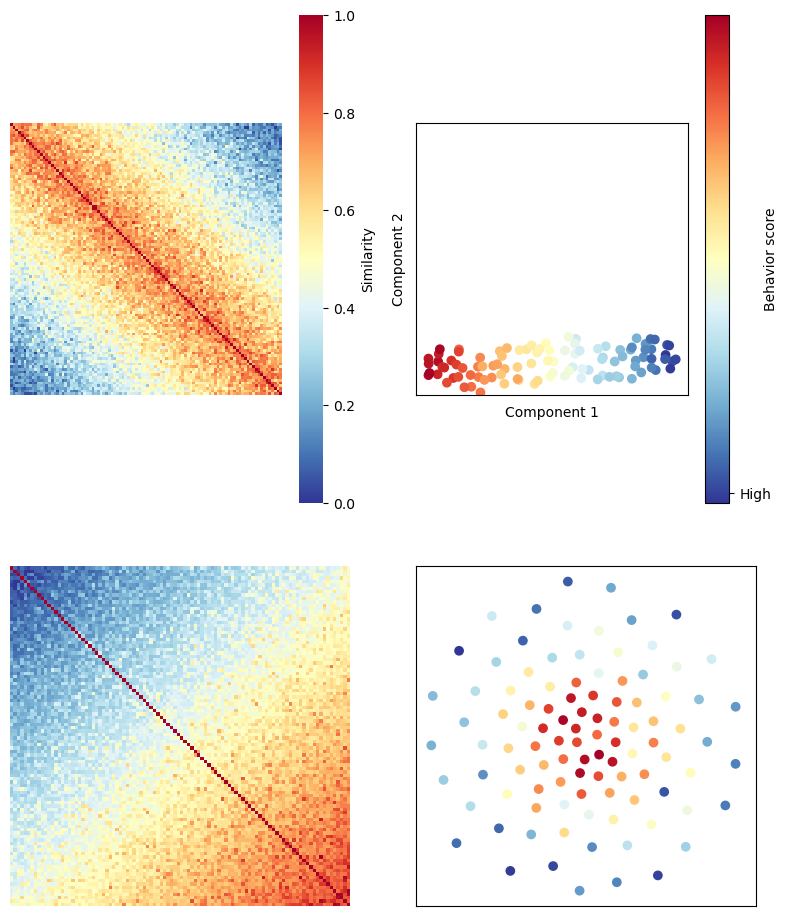

In [11]:
list_of_matrices = [nn_mtx, annak_mtx]

fig, axes = plt.subplots(len(list_of_matrices), 2, figsize = (8,10))

for m, mtx in enumerate(list_of_matrices):
    ax1 = axes[m, 0]
    ax2 = axes[m, 1]
    
    # Draw heatmap
    if m ==0:
        cbar = True
    else:
        cbar = False
        
    sns.heatmap(sort_square_mtx(mtx, behav), ax=ax1, 
                cmap=cmap, square=True, cbar=cbar, cbar_kws = {'label': 'Similarity'},
                xticklabels=False, yticklabels=False)
    
    # Draw tSNE plot
    # Note that TSNE operates on distance matrices, so because our simlarity matrices are already scaled 
    # to be between 0 and 1, we can convert easily by doing (1 – similarity matrix)
    isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1 - mtx) 
    scatter_p = ax2.scatter(isc_embedded[:,0], isc_embedded[:,1], c=behav, cmap=cmap)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    if m ==0:
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        # cbar.ax2.set_xticklabels(['Low', 'High'])
        
    ax2.axis('square')
    ax2.set(xlim = ax2.get_xlim(), ylim = ax2.get_ylim())

cbar = fig.colorbar(scatter_p, ax = axes[0,1], ticks = [-2, 2])
cbar.ax.set_yticklabels(['Low', 'High'])
cbar.set_label('Behavior score', labelpad = -5)

plt.tight_layout()

In this study, the main variable of interest was trait paranoia, which was measured using the Paranoid Thoughts Scale A (Green et al., 2008). This is a self-report questionnaire that asks participants to rate how strongly they agree with statements relating to paranoid ideation over the last month. Some examples are : "I spent time thinking about friends gossiping about me", "People have been dropping hints for me", "I was frustrated by people laughing at me." There are 16 items and each item is rated on a scale from 1 (not at all) to 5 (totally). Therefore, the minimum possible score is 16 and maximum possible score is 80.

This was a sample of all healthy participants (no diagnosis of schizophrenia or other mental illness) so we expect most scores to be on the lower end of the spectrum. Still, trait paranoia varies even among the general population, and this study was designed to look at how normative variation in this trait relates to brain responses to an ambiguous social narrative.

Note that trait measures suffer from a number of issues (e.g. self-report) but are still commonly used. 
IS-RSA can be used with any type of subject level data including behavioral data (Chen et al., 2020) or a computational model (van Barr et al., 2019)

In [12]:
# Check demographic and behavioral info of participants
behav_data = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')
behav_data.head()

participant_id  age sex  gptsa_score
0     sub-tb2994   27   M           22
1     sub-tb3132   28   F           16
2     sub-tb3240   25   M           18
3     sub-tb3279   20   M           20
4     sub-tb3512   34   M           18

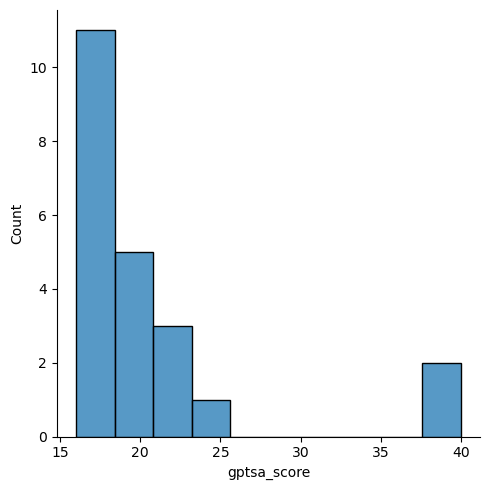

In [18]:
# Histogram of GPTS-A scores
behav = behav_data["gptsa_score"]

sns.displot(behav)

GPTS-A scores follow a pretty skewed distribution in our sample of 22 participants, with most participants scoring fairly low and only a couple scoring higher. This is not necessarily ideal but also not uncommon for a scale like this. For some analyses, we might be worried about these two extreme values driving some or all of our effects, but in RSA it's common to use rank-based similarity metrics (i.e. Spearman correlation instead of Pearson). This means that subjects are not their absolute score, but rather their rank relative to other subjects, thus these two extreme scorers will not be overweighted. 

In our case, you can think of our behavior as following a uniform distribution of ranks between 1-22, with some ties where 2 or more subjects had the same raw score.

<AxesSubplot:ylabel='Count'>

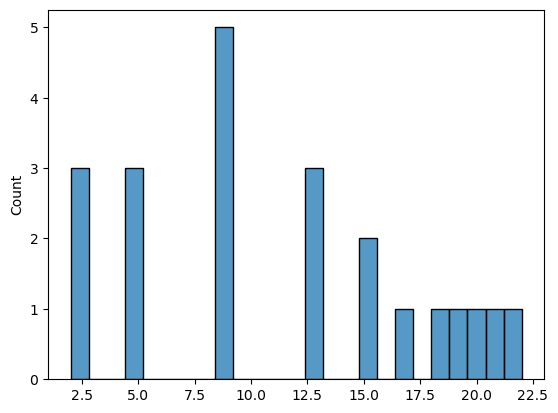

In [42]:
behav_rank = rankdata(behav)

sns.histplot(behav_rank, bins=25)
#sns.countplot(behav_rank)

## Brain data

We will use a functional parcellation called the Shen atlas (Shen et al., 2013). Let's load our parcellation image and initialize a masker object from nilearn that will allow us to average voxels in each individual node.

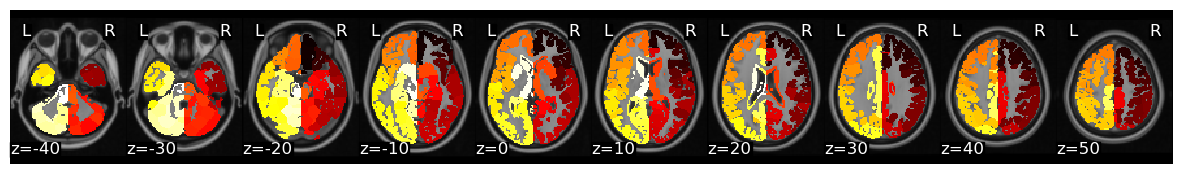

In [43]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=True)

(526, 268)


<AxesSubplot:>

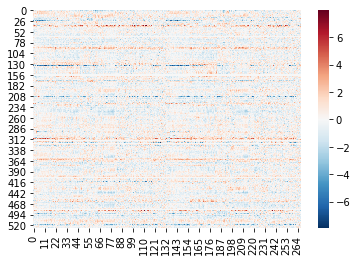

In [13]:
# Try the masker on the first subject to see if it's working
sub = 'sub-tb2994'
fmri_file = os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_denoise_smooth6mm_task-story_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

time_series = masker.fit_transform(fmri_file)
print(time_series.shape)

sns.heatmap(time_series, cmap='RdBu_r')

The array has the correct shape : 526 TRs (the length of run 1) x 268 nodes. When we visualize it as a heatmap we can see that values look reasonable : centered around 0 (which we would expect given that the masker function normalized the data by default), and no stripe-y-artifacts that look too concerning.

Next, we'll create node time series for all subjects for all runs. There are 22 subjects, each with 3 runs, so this will take a while. To speed this up, we have already run the code and shared the extracted csv files in the datalad repository.

In [ ]:
# Run this if you want to extract data yourself, after the correct data is downloaded

subj_list = behav_data["participant_id"]

for subj in subj_list:    
    for run in [1, 2, 3]:
        time_series_fname = os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')
        if os.path.exists(time_series_fname):
            print(f"Node time series file for {subj}, run {run} already exists!")
        else:
            print(f"Creating node time series for {subj}, run {run}")
            time_series = masker.fit_transform(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_denoise_smooth6mm_task-story_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
            pd.DataFrame(time_series).to_csv(time_series_fname, index=False)


In [48]:
# Load text files containing the nodewise timeseries. 
# As we load them, we stack them into a 3d array that is subjects x TRs x nodes.
subj_list = behav_data["participant_id"]

data = []
for subj in subj_list:
    sub_data = []
    for run in range(1,4):
        sub_data.append(pd.read_csv(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')))
    sub_data = pd.concat(sub_data)
    data.append(sub_data.values)
data = np.array(data)

In [49]:
data.shape

(22, 1310, 268)

In [50]:
# Save the dimensions :
# 22 subjects x 1310 TRs (number of timepoints in all runs) x 268 nodes

n_subs, n_ts, n_nodes = data.shape

## Calculate Brain Similarity

We will use intersubject correlation (ISC) as our measure of brain similarity. ISC is the Pearson correlation of activity in the same spatial location across two or more subjects. Because all subjects heard the same time-locked story, any correlated activity across brains likely reflect processing of the stimulus.

Keep in mind that, in theory, we could calculate brain similarity based on any type of information we can extract from single subjects' neuroimaging data. For now, we use ISC because it is straightforward to compute, visualize, and interpret.

We'll calculate one ISC matrix (dims subjects x subjects) for each of out 268 nodes. We use pairwise_distances from scikit learn to comput the distance matrix as it is much faster than np.corrcoef and can comput many different types of distance. When we use correlation, we can easily convert it into similarity by subtracting the values from 1. (1 - distance = similarity). We also store the similarity/distance matrices in an nltools.data.Adjacency instance to make it easier to perform operations on the matrix.

In [51]:
similarity_matrices = []
for node in range(n_nodes):
    similarity_matrices.append(Adjacency(1 - pairwise_distances(data[:, :, node], metric='correlation'), matrix_type='similarity'))
similarity_matrices = Adjacency(similarity_matrices)

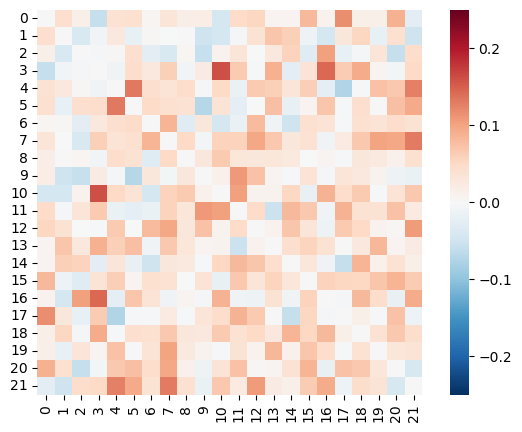

In [52]:
# Visualize one matrix
similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

This looks reasonable: most values are positive (negative distance is not interpretable?), and there is some variance in correlation strength across subject pairs. (Ignore the diagonal as they are perfect correlations to themselves)

Let's see which nodes show the highest ISC across the whole group. We will compute the mean (or median) of the lower triangle of the matrix using the Adjacency.isc method. We could also get the p-values using the subject-wise bootstrapping method (Chen et al., 2016).

To make the code more concise, we run this using a dictionary comprehension which is like an inplace for loop that creates a Python dictionary.

In [53]:
isc = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['isc'] for node in range(n_nodes)}

In [54]:
expand_mask(mask)

nltools.data.brain_data.Brain_Data(data=(268, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

We can combine the ISC values with the Shen k=268 mask to plot the ISC values on the brain. The nltools.mask.roi_to_brain function needs an array of ISC values in an order that corresponds to an image with a binary mask for eabch ROI. We create that using the nltools.mask.expand_mask function. Finally, we plot the results using any of the nilearn plotting functions by casting our Brain_Data instance back into a nibabel instance with the .to_nifti() method.

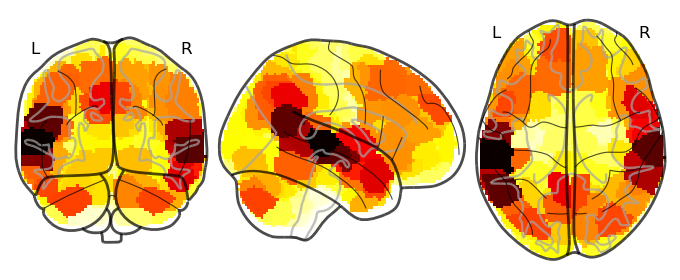

In [117]:
isc_brain = roi_to_brain(pd.Series(isc), expand_mask(mask))

plot_glass_brain(isc_brain.to_nifti())

It looks like the highest synchrony was in the superior temporal cortex, which makes sense given that these areas are involved in auditory processing and language. Visual regions aren'y particularly synchronized, which also makes sense since this was a purely audio story. But there is also some interesting synchrony in the temporo-parietal junction, anterior temporal lobe, parts of the prefrontal cortex, and posterior cerebellum. This may be a hint that above and beyond receiving the same low-level auditory and linguistic input, participants' higher-level processing of the stimulus may have been somewhat similar as well.

That was a good sanity check, but what we really want to know is where ISC is higher among pairs of participants that are also more similar in behavior score.

## Calculate Behavior Similarity
There are multiple ways to calculate behavioral similarity, and the metric we choose both implies something about our assumptions for what the similarity structure should look like and affects how we interpret results.

Let's extract our vector of scores for the behavior we're interested in.

In [56]:
behav = behav_data["gptsa_score"]
behav_rank = rankdata(behav) # explicity convert the raw scores to ranks

We will explore both types of similarity structures presented above (nearest-neighbor and Anna K) to see which is a better fit for our data.

We'll start by calculating the "nearest-neighbors" behavioral similarity matrix. The metric is Euclidean distance, or the difference between two subject's ranks. While RSA operates equally well on similarity and distance matrices, it is a bit easier to keep things straigt when both behavioral and ISC matrices are of the same type.
As ISC is inherently a similarity measure (higher score = more similar), and Euclidean distance is inherently a distance measure (higher score = less similar), we'll convert the Euclidian distances to similarities using the Adjacency.distance_to_similarity method.
This makes it more straighforward when interpreting positive RSA r-values as reflecting a higher representational similarity between brain and behavior.

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

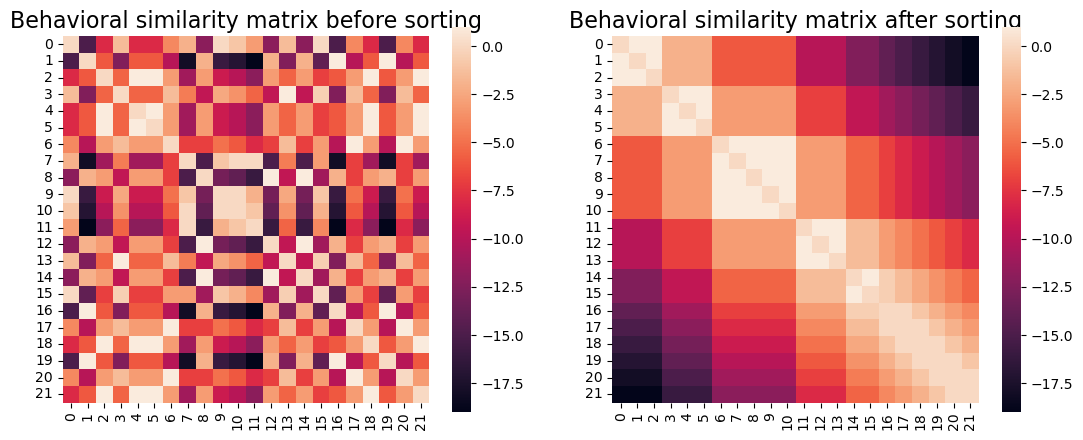

In [57]:
# Nearest Neighbors
behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
behav_sim_nn = behav_sim_nn.distance_to_similarity()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

# Sort subjects in order of score rank from low to high
sns.heatmap(sort_square_mtx(behav_sim_nn.squareform(), behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

After sorting subjects in order of paranoia score rank, the expected diagonal structure, where each subject is more similar to its immediate neighbors, become clearly visible. However, this matrix is only for purposes of visualization. For our IS-RSA analyses, we want to use the original matrix to make sure that subject order matches our ISC matrices.

Now, we'll construct behavioral similarity matrix reflecting the "Anna Karenina" structure. The metric for this is the mean of two subjects' ranks, which we'll normalize by the highest possible rank (the number of subjects).

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

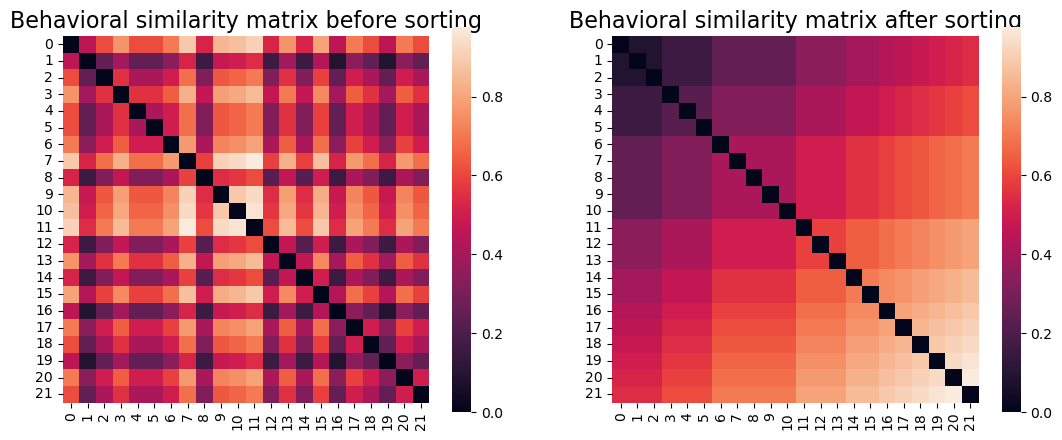

In [58]:
# Anna Karenina
behav_sim_annak = np.zeros((n_subs, n_subs))

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            sim_ij = np.mean([behav_rank[i], behav_rank[j]])/n_subs
            behav_sim_annak[i,j] = sim_ij
            behav_sim_annak[j,i] = sim_ij
        elif i==j:
            behav_sim_annak[i,j] = 1

# Adjacency class represents adjacency matrices as a vector rather than a 2-d matrix
behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(behav_sim_annak.squareform(), behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

Is it what we expected in the sorted similarity matrix?
Similarity increases as you move down and to the right, reflecting the idea that pairs of participants that score higher on trait paranoia should be more similarity than pairs of low-scoring participants.

One convenient feature of operationalizing the similarity matrix in this way is that the same model can detect effects in both directions, based on the sign of the resulting r-value between brain and behavioral similarity matrices. If high scorers are alike and low scorers different, the resulting r-value would be positive; if low scorers are alike and high scorers different, it would be negative. This means we don't have to run two different models to check for effects in different directions.

## Compute IS-RSA
Now that we have similarity matrices for both brain and behavior data, we can do intersubject RSA.

Rather than finding the central tendency of the pairwise relationships, or the reliability of the signal, by computing the mean for ISC we instead explore that structure of the variations in the pairwise relationships with IS-RSA. This is computed using representational similarity analysis, where we vectorize the lower triangle of the pairwise neural ISC and correlate it with the vectorized lower triangle of the pairwise behavioral ISC. Because we don't necessarily assume that there will be a linear relationship, particularly as we used different distance metrics (i.e. correlation and euclidean distance), we typically use Spearman 𝜌 ranked correlations.

Let's loop over nodes and compute the similarity between the brain (similarity_matrices) and each of the competing hypothesis reflected in the NN and AnnaK similarity matrices (behav_sim_nn, behav_sim_annak).

In [59]:
isrsa_nn, isrsa_annak = {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

# Plot correlation values back on the brain
isrsa_nn_brain = roi_to_brain(pd.Series(isrsa_nn), expand_mask(mask))
isrsa_annak_brain = roi_to_brain(pd.Series(isrsa_annak), expand_mask(mask))

/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


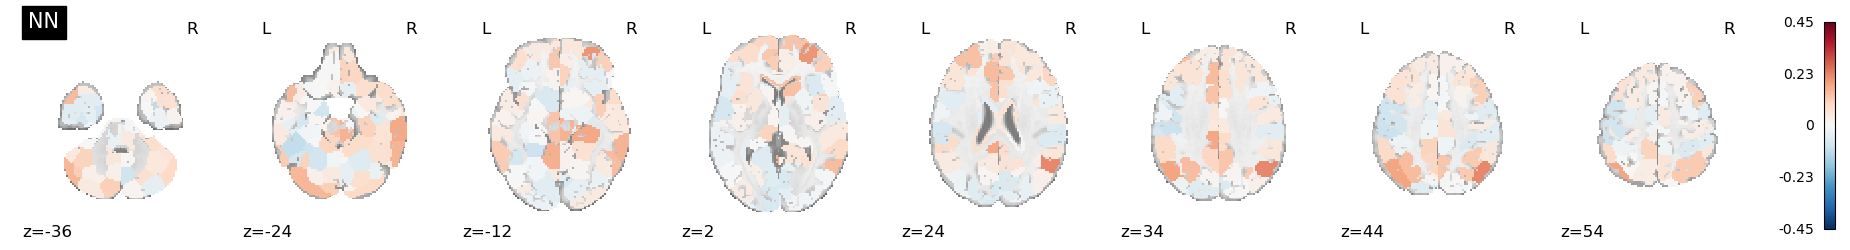

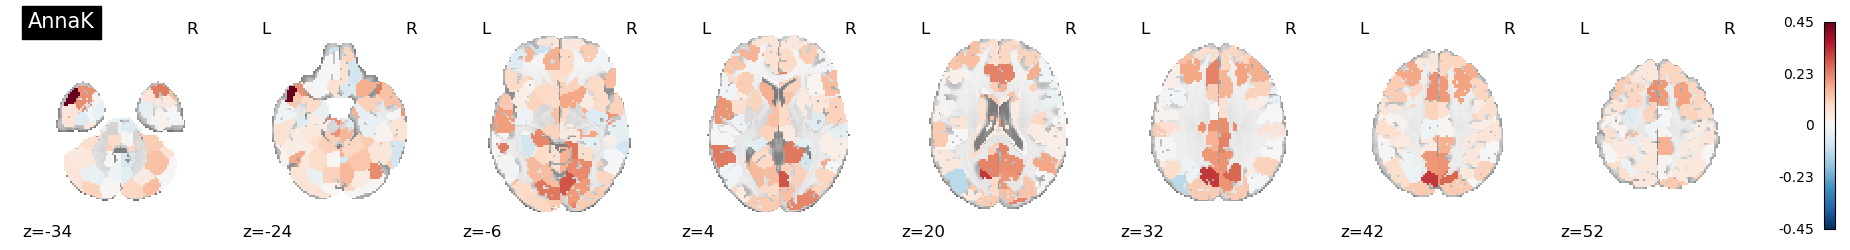

In [60]:
# Plot an axial montage of each of the ISRSA maps using the same colorscale to make it easier to compare

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax = np.max(np.abs([list(isrsa_nn.values()), list(isrsa_annak.values())]))

plot_stat_map(isrsa_nn_brain.to_nifti(), display_mode='z', cut_coords=8, vmax=vmax, title = "NN", cmap='RdBu_r')
plot_stat_map(isrsa_annak_brain.to_nifti(), display_mode='z', cut_coords=8, vmax=vmax, title = "AnnaK", cmap='RdBu_r')

Some of the nodes with the highest IS-RSA values for the nearest neighbor model are in the angular gyrus/temporo-parietal junction (typical "default mode" region), and the lateral prefrontal cortex. The Anna Karenina model also has high IS-RSA values in the angular gyrus, but also in the PCC and dACC.

## Comparing different models
We can look at the distribution of RSA r-values across all nodes to see if there is generally some level of representational similarity between brain and behavior. We can test if this distribution is significantly shifted from zero using a one-sample t-test. Note that this doesn't tell us which, if any, individual nodes show significant representational similarity, but it can tell us if there is significant representational similarity at the whole-brain level.

Text(0.2, 40, 't=13.75, p = 0.000')

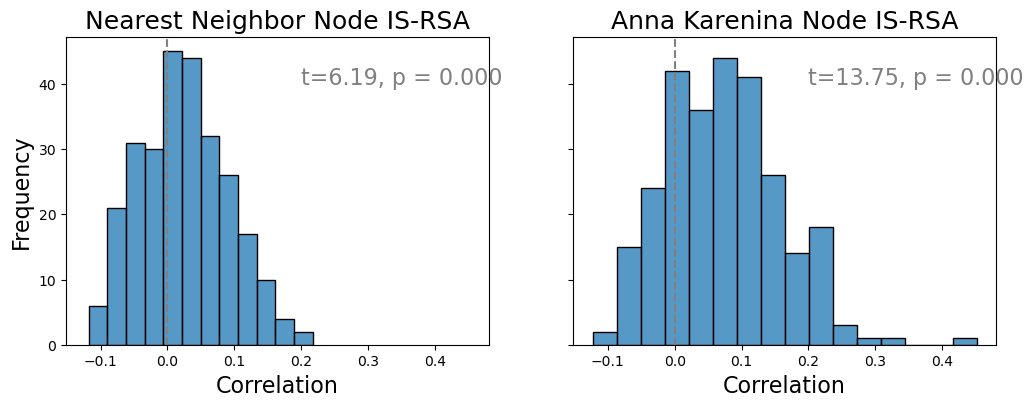

In [61]:
f, a = plt.subplots(ncols=2, figsize=(12,4), sharex=True, sharey=True)
sns.histplot(list(isrsa_nn.values()), ax=a[0])
a[0].axvline(0, color='gray', linestyle='--');
a[0].set_ylabel('Frequency', fontsize=16)
a[0].set_xlabel('Correlation', fontsize = 16)
a[0].set_title('Nearest Neighbor Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(isrsa_nn.values()), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')

sns.histplot(list(isrsa_annak.values()), ax=a[1])
a[1].axvline(0, color='gray', linestyle='--');
a[1].set_ylabel('Frequency', fontsize=16)
a[1].set_xlabel('Correlation', fontsize = 16)
a[1].set_title('Anna Karenina Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(isrsa_annak.values()), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')

We see that the values are generally shifted positive (the expected direction), meaning that there is more representational similarity between brain and behavior than we would expect by chance.

We can also test if the mean of the two distributions are significantly different from each other using a paired samples t-test.

t=-7.43, p = 0.000


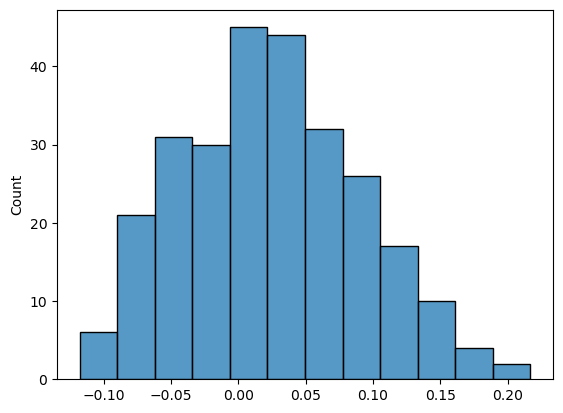

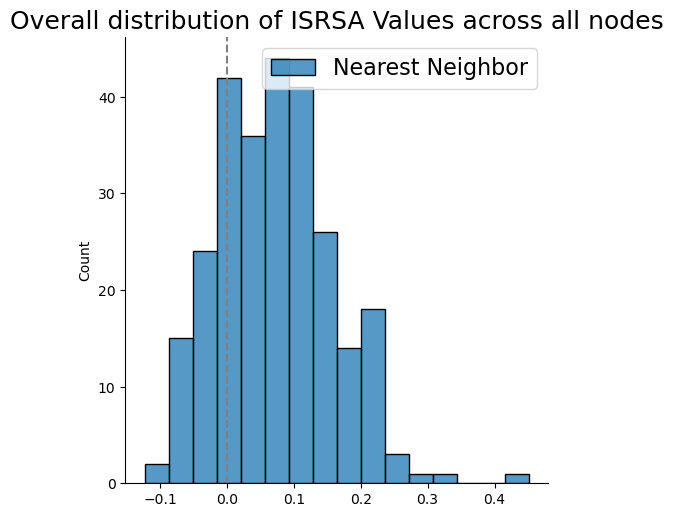

In [62]:
sns.histplot(list(isrsa_nn.values()))
sns.displot(list(isrsa_annak.values()))
plt.legend(['Nearest Neighbor', 'Anna Karenina'], fontsize=16)
plt.title('Overall distribution of ISRSA Values across all nodes', fontsize=18)
plt.gca().axvline(0, color='gray', linestyle='--');

t, p = ttest_rel(list(isrsa_nn.values()), list(isrsa_annak.values()))
print(f't={t:.2f}, p = {p:.03f}')

Another way to visually compare results from the two models is with a scatterplot. Each dot is a node, and we also plot the identity line (where y=x, not the regression line). If the NN and AnnaK models gave identical results, all the dots would fall on this diagonal line. If some dots are above and some dots are below, it means that different nodes are best fit by different models (some by NN, others by AnnaK). If most of the dots are above (rather than below) the line, it means that overall the AnnaK model is better of the majority of nodes.

Text(0, 0.5, 'AnnaK r value')

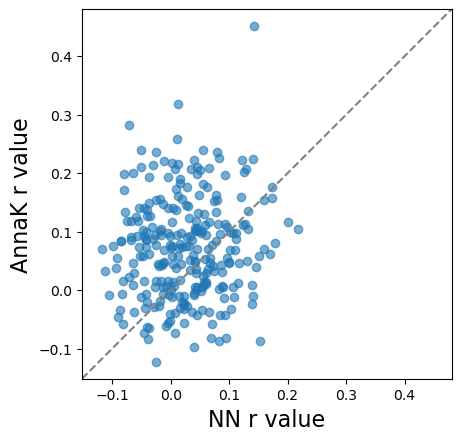

In [64]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
fig, ax = plt.subplots()

ax.scatter(list(isrsa_nn.values()), list(isrsa_annak.values()), alpha=.6)

line = mlines.Line2D([0, 1], [0, 1], color='gray', linestyle='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
set_aspect_ratio(ax)
ax.set_xlabel("NN r value", fontsize=16)
ax.set_ylabel("AnnaK r value", fontsize=16)

In our case, some dots are above and below the line with a bit more above the line than below. Thus, we can say that different nodes are fit by the two models with the AnnaK model fitting more nodes than the NN model.

## Hypothesis Tests
It’s easy enough to calculate a correlation coefficient between the upper triangles of two similarity matrices, but we need to be careful when assessing the statistical significance of this correlation. Parametric p-values won’t work here, since the values in each matrix are not independent: each value is associated with two subjects, meaning that any two values that share a row or column are not independent. In other words, the value for (i,j) is not independent from the value for (i,k), since they share subject i.

This means that we need to calculate significance non-parametrically, by randomly shuffling one of the matrices in a way that respects this complicated dependence structure (**permutation**). We can do this by simply making sure we permute rows and columns at the same time. One easy way to think about this is, in the case of the behavioral similarity matrix, it’s as if we shuffled behavior scores across subjects and recalculated the behavioral similarity matrix. (Or, in the case of the brain similarity matrix, it’s as if we shuffled node timeseries across subjects and recalculated the ISC matrix.) Then we correlate this shuffled matrix with the second matrix, and we do this a large number of times to build up a distribution for the correlation we might expect by chance.

We will use the Adjacency.similarity method again, but now we will specify the number of permutation with n_permute=5000 and the number of CPUs to use with n_jobs. If n_job=-1, the function will parallelize the permutations using all available CPUs.

Note: running these permutation tests over all nodes for both models will take approximately 30 min as it requires running over 2.6 million correlations (2 models X 268 nodes X 5000 permutations).

In [ ]:
isrsa_nn_r, isrsa_nn_p = {}, {}
isrsa_annak_r, isrsa_annak_p = {}, {}
for node in range(len(similarity_matrices)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    stats_nn = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=5000, n_jobs=-1 )
    isrsa_nn_r[node] = stats_nn['correlation']
    isrsa_nn_p[node] = stats_nn['p']
    
    stats_annak = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=5000, n_jobs=-1 )
    isrsa_annak_r[node] = stats_annak['correlation']
    isrsa_annak_p[node] = stats_annak['p']

isrsa_nn_r_brain = roi_to_brain(pd.Series(isrsa_nn_r), expand_mask(mask))
isrsa_nn_p_brain = roi_to_brain(pd.Series(isrsa_nn_p), expand_mask(mask))

isrsa_annak_r_brain = roi_to_brain(pd.Series(isrsa_annak_r), expand_mask(mask))
isrsa_annak_p_brain = roi_to_brain(pd.Series(isrsa_annak_p), expand_mask(mask))

Feel free to explore the IS-RSA values with the interactive plots. The values should be identical to the analyses run above. However, we now we have p-values to evaluate the likelihood we would observe these values by chance.

Nearest-Neighbor Model


/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



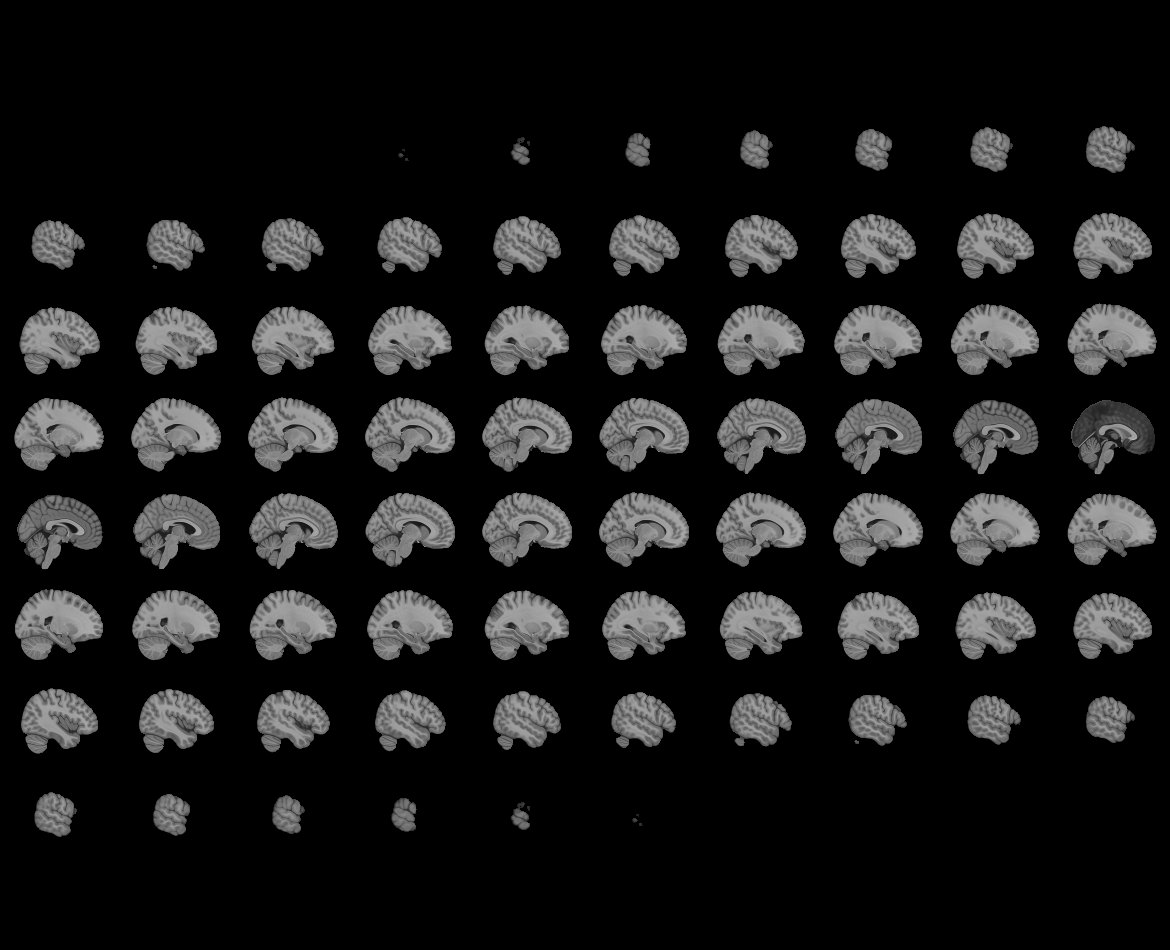
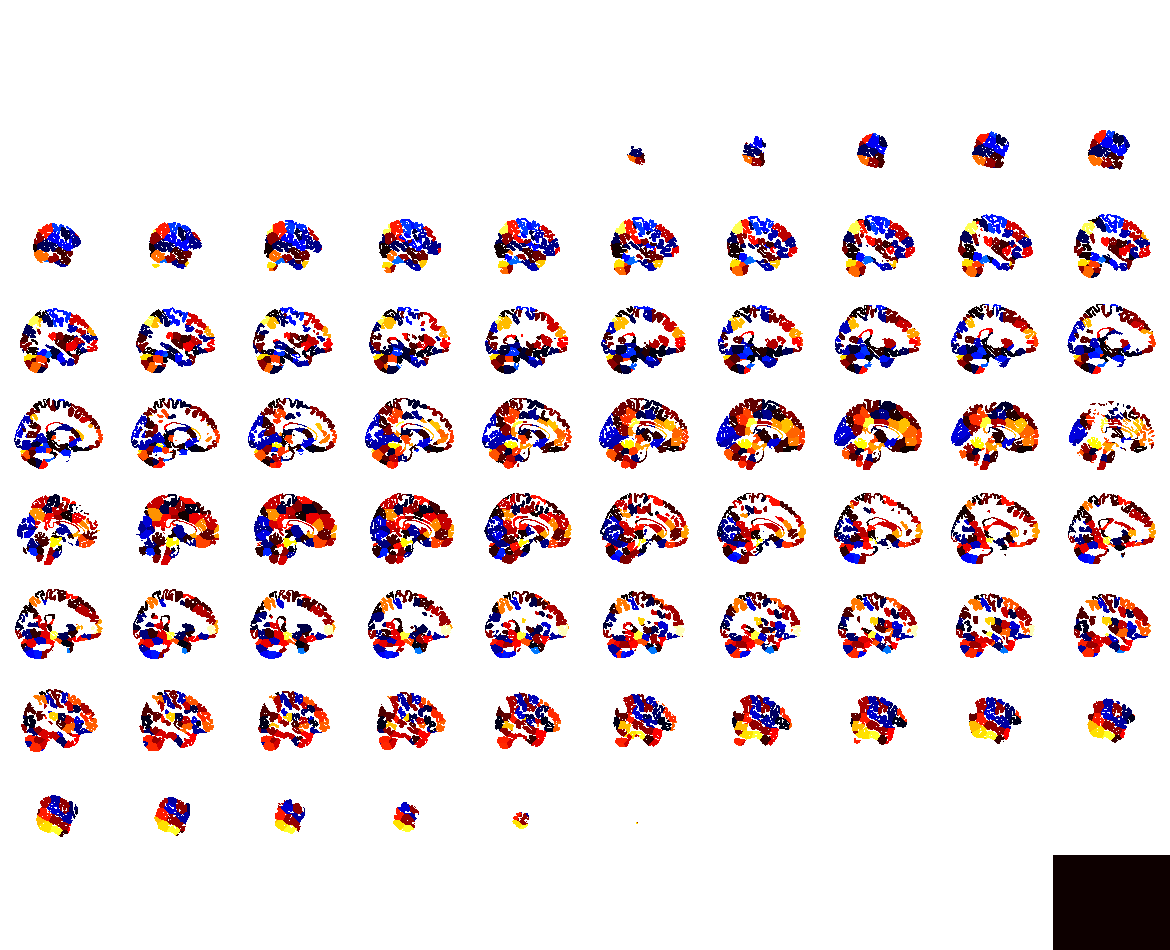

In [66]:
print('Nearest-Neighbor Model')
view_img(isrsa_nn_r_brain.to_nifti())

Anna Karenina Model


/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



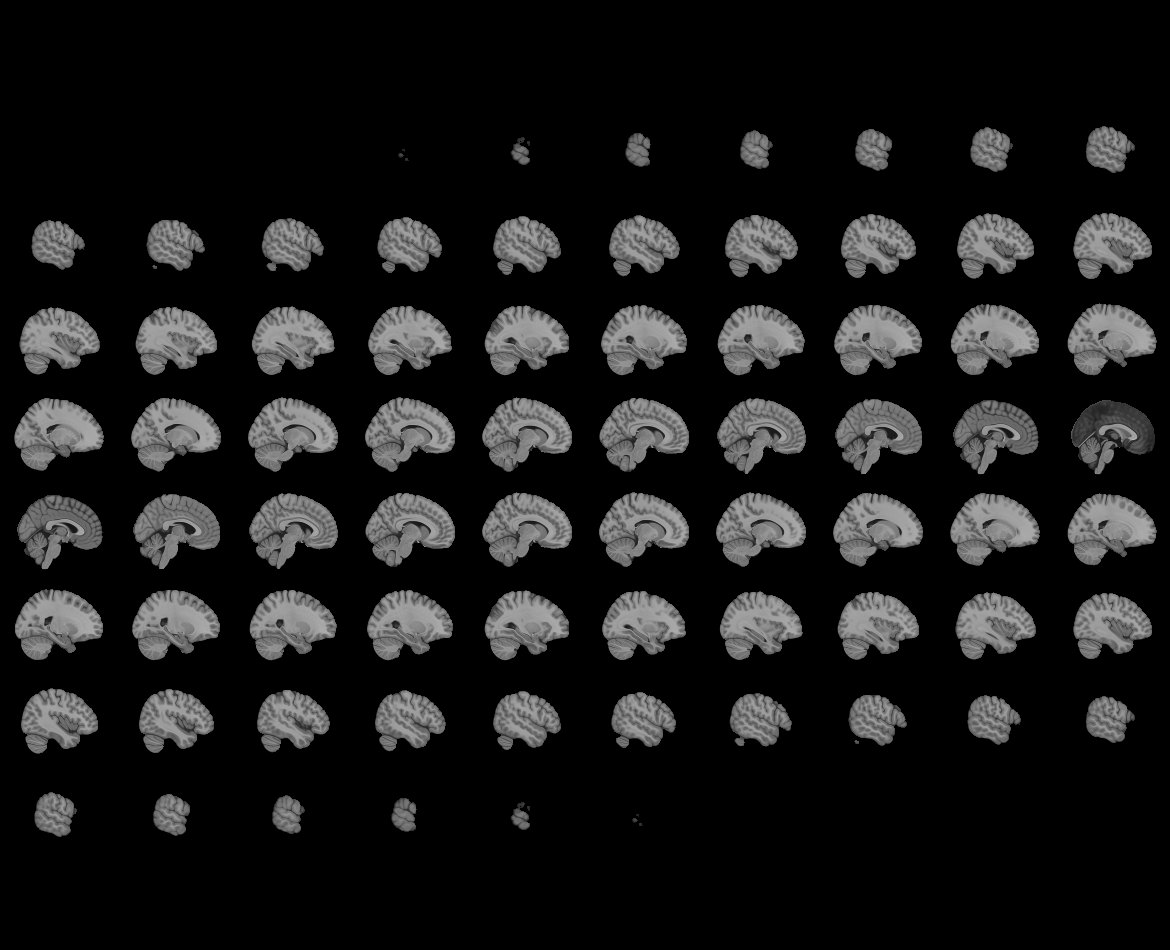
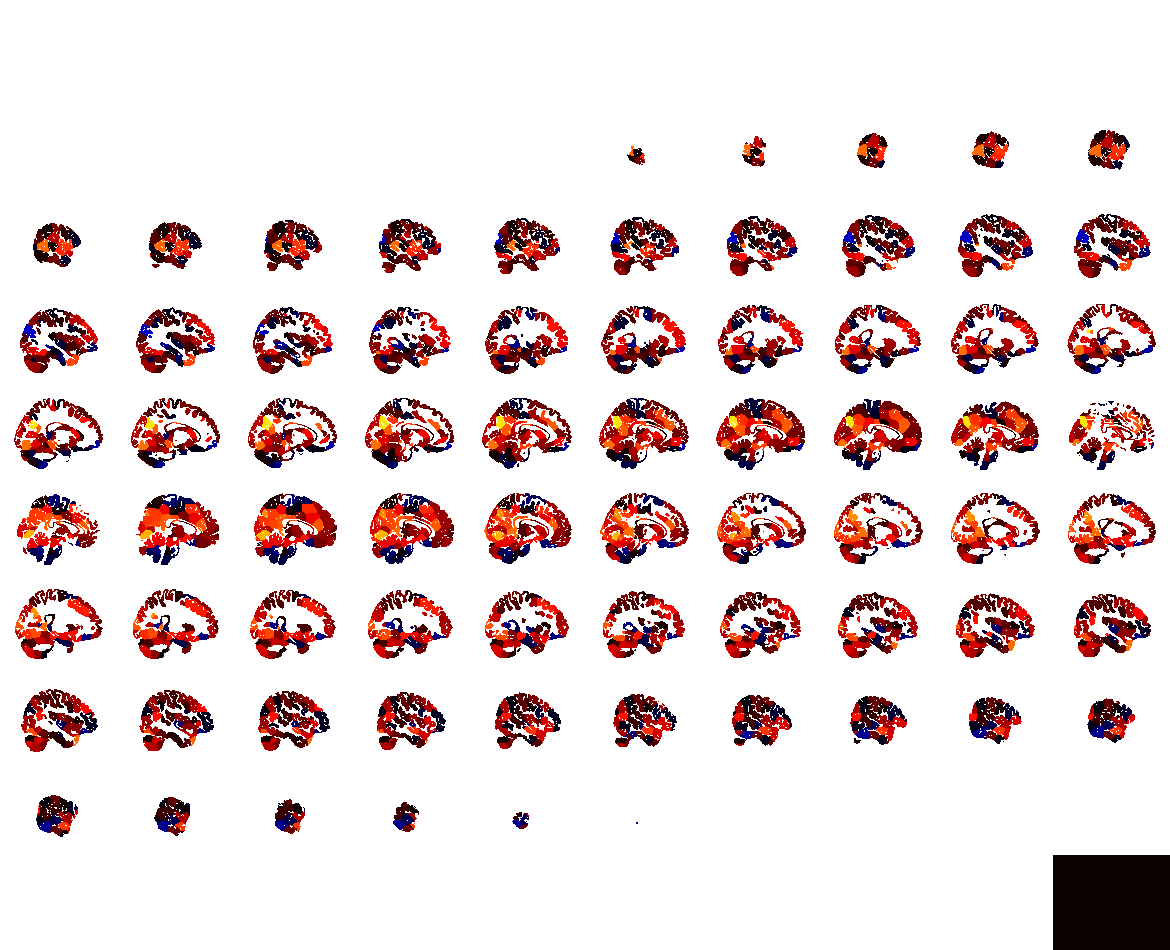

In [67]:
print('Anna Karenina Model')
view_img(isrsa_annak_r_brain.to_nifti())

Correcting for multiple comparisons

If we want to make inferences about the significance of representational similarity at individual nodes, we need to correct for multiple comparisons (since for each model we’ve run 268 tests – one for each node). We could use Bonferroni correction, where we divide our alpha threshold (typically 0.05) by the number of tests we’ve run (268) to get a corrected alpha threshold (in this case 0.05/268 = 0.00019), but this is probably too conservative, resulting in many false negatives. An alternative is to use the false discovery rate method (FDR) to give us better power (Benjamini & Hochberg, 1995). 

FDR Threshold: 0.023395320935812838


/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/plotting/html_document.py:63: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



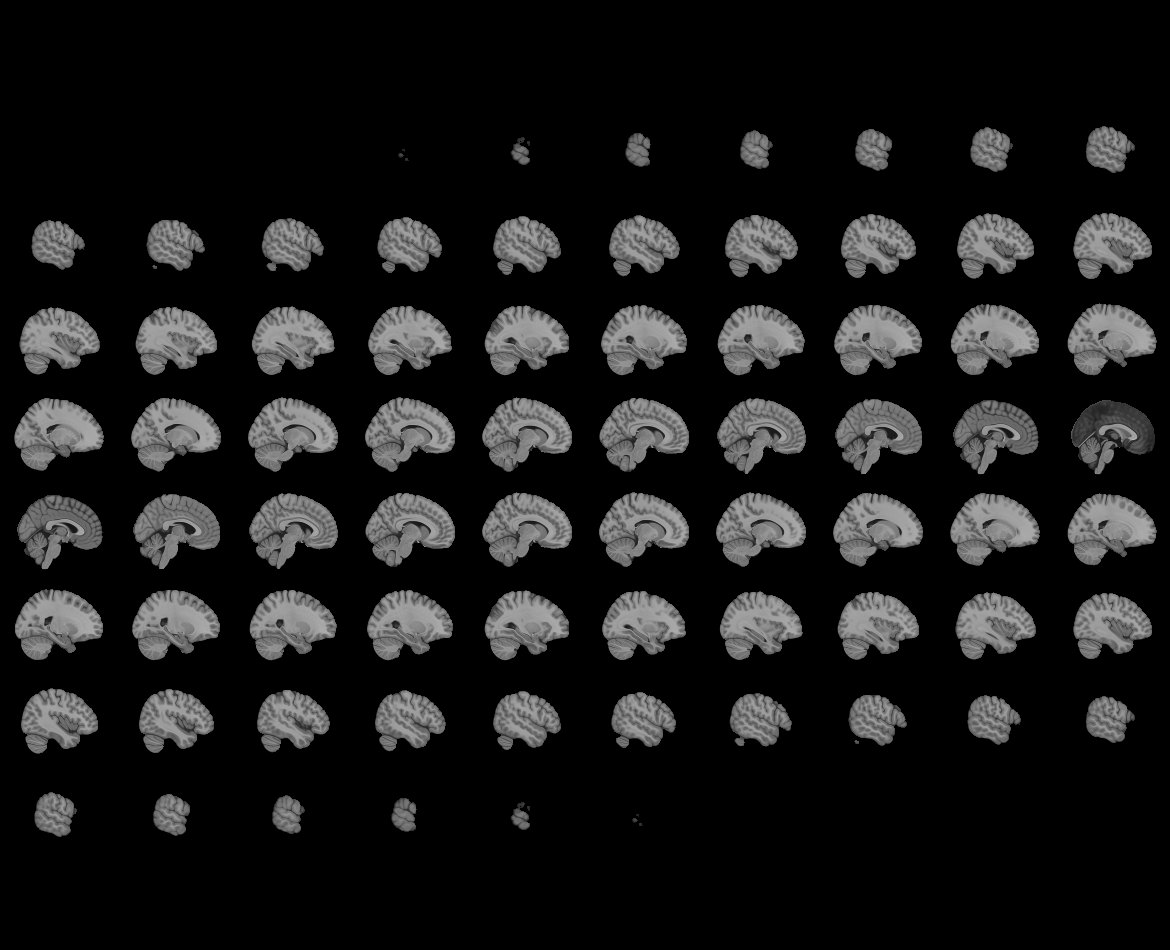
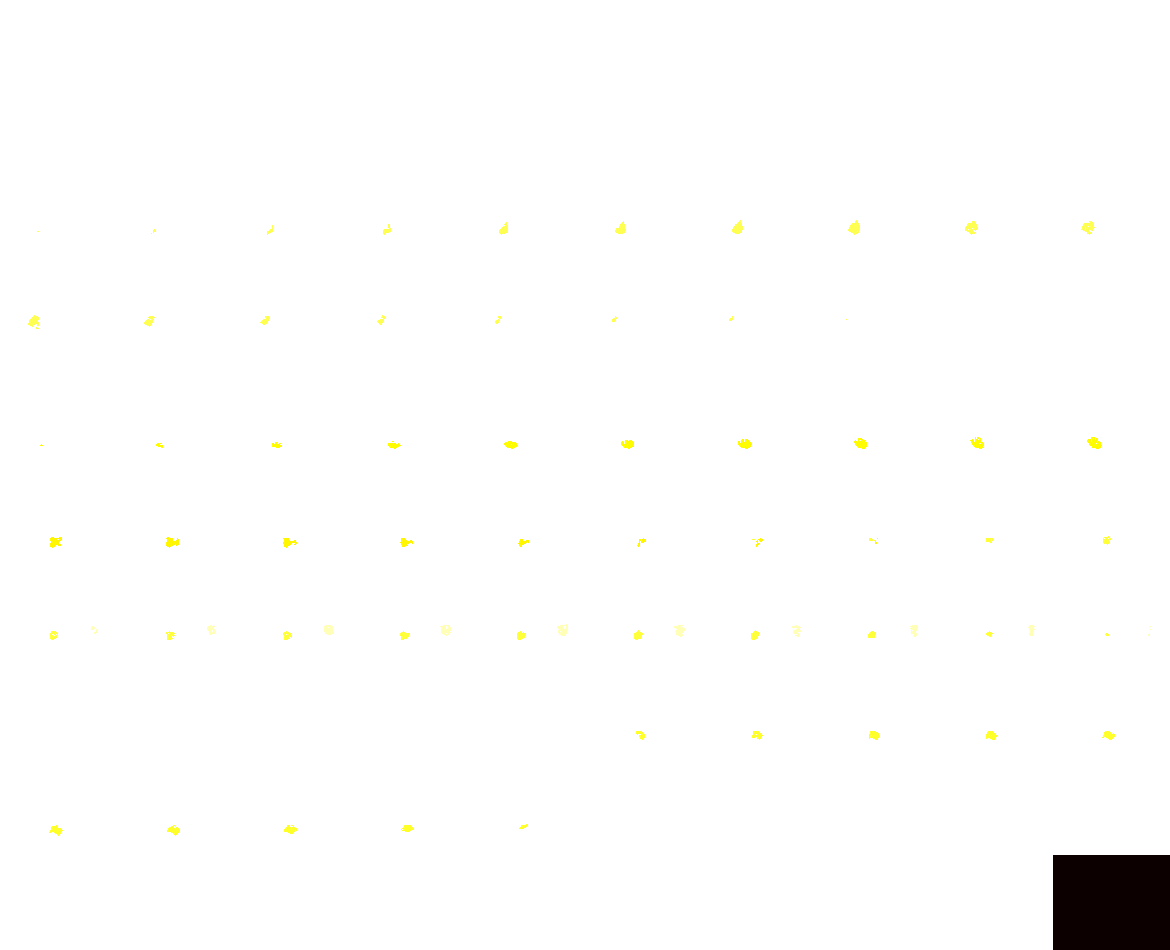

In [103]:
# NN model
fdr_thr = fdr(pd.Series(isrsa_nn_p).values, q=0.8)
print(f'FDR Threshold: {fdr_thr}')

view_img(threshold(isrsa_nn_r_brain, isrsa_nn_p_brain, thr=fdr_thr).to_nifti())

With the fdr level q=0.05, no regions survive correction. If we set the fdr level q=0.8, the FDR threshold is fairly low p < 0.0234. Then, there are several nodes in the hippocampus, PCC, parietal cortex, cerebellum, and right lateral PFC that survive this threshold.

FDR Threshold: -1


/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/masking.py:916: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:74: UserWarning: The given float value must not exceed 0. But, you have given threshold=1e-06 
  threshold))
/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/naeun-oh/miniconda3/envs/naturalistic37/lib/python3.7/site-packages/nilearn/image/resampling.py:545


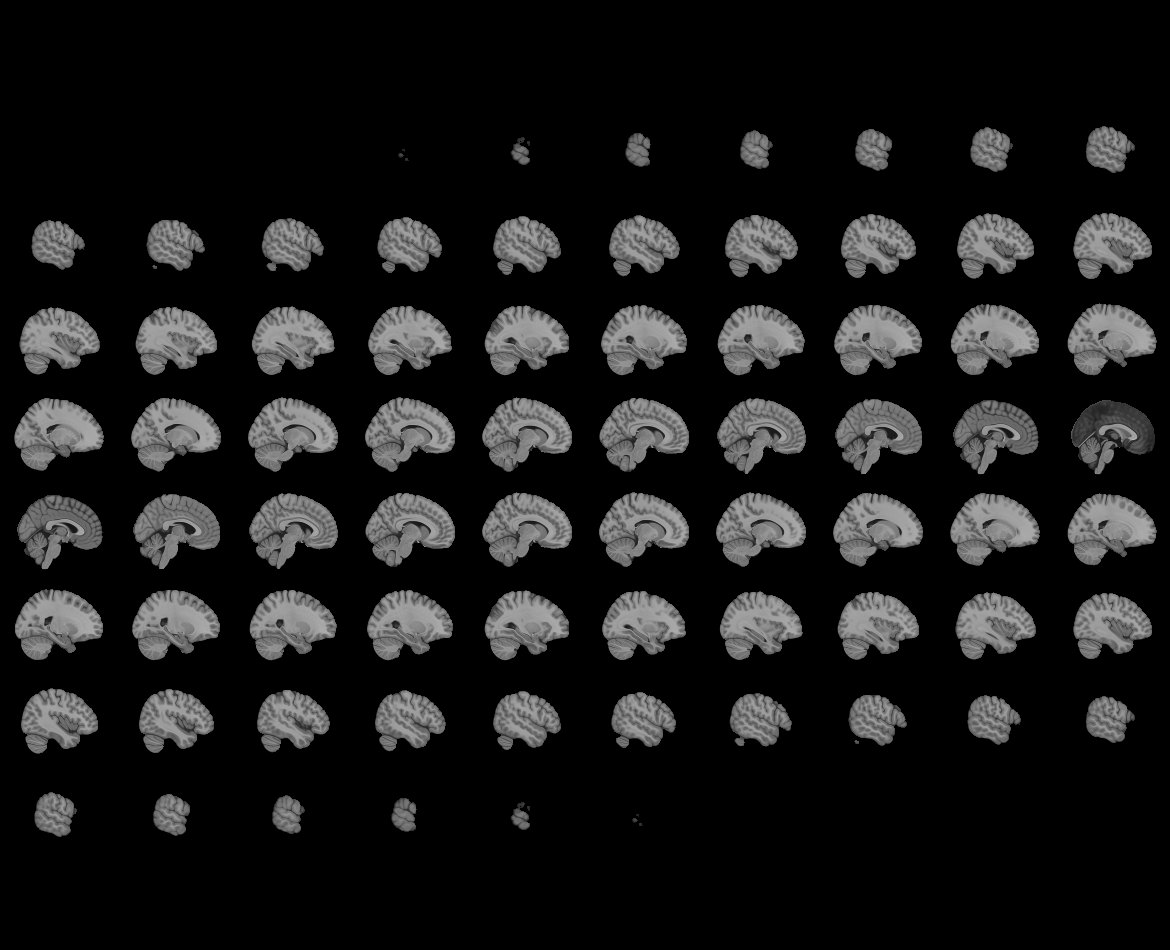
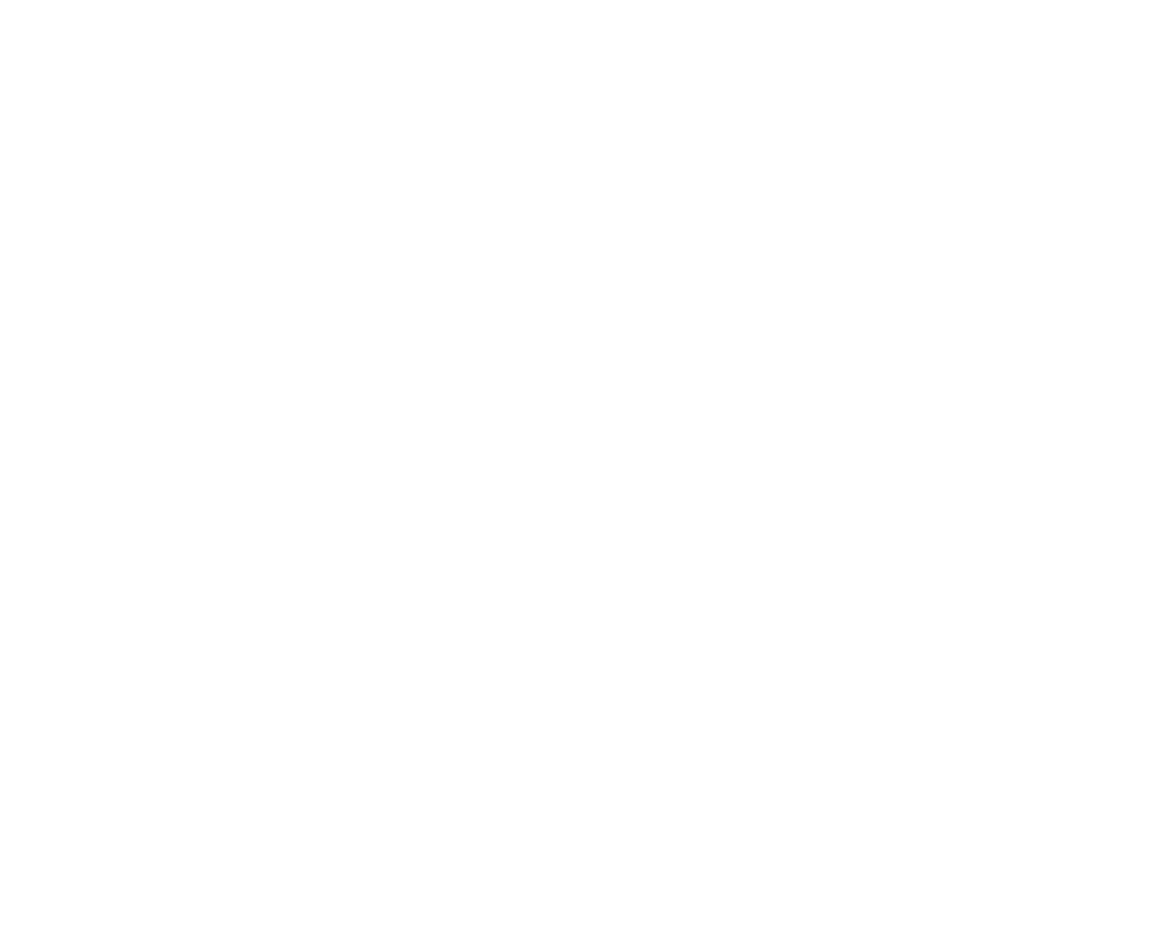

In [116]:
# AnnaK model
fdr_thr = fdr(pd.Series(isrsa_annak_p).values, q=0.8)
print(f'FDR Threshold: {fdr_thr}')

view_img(threshold(isrsa_annak_r_brain, isrsa_annak_p_brain, thr=fdr_thr).to_nifti())

It seems that no regions survive correction. And if we set the fdr level high (q=0.81), the threshold is too high to interpret significance (p<0.2).

Why might this happen? It's likely due to a lack of power. With only 22 subjects, it's difficult to detect brain-behavior relationships.

The original paper (Finn et al., 2018) took a voxelwise approach, which greatly increased computational complexity and the number of tests, but it also allowed them to take advantage of cluster-based correction, which is another way to control the family-wise error rate that leverages the spatial structure of the data (based on the assumption that if manu contiguous voxels are significant, it's unlikely to be due to chance).

In our case, using a parcellation approach lowered computational costs, but we may lose sensitivity and we are not able to use cluster correction or other spatial methods.